# Keras에서 앙상블 학습을 사용한 말라리아 기생충 탐지

앙상블 학습은 여러 모델의 예측을 결합하여 예측 정확도를 향상시킵니다.

앙상블 학습을 수행하는 방법에는 여러 가지가 있으며 https://en.wikipedia.org/wiki/Ensemble_learning 을 참조하세요.
앙상블 학습에는 두 가지 주요 클래스가 있습니다.
- Bagging: 독립적인 모델을 학습시킨 다음 그 것들의 예측을 평균합니다.
- Boosting: 여러 모델을 순차적으로 학습시킨 다음 예측의 평균을 냅니다.

이 노트북에서는 배깅 방식의 단순화된 형태를 사용할 것입니다.

- 독립 모델들을 훈련
- 각각의 예측을 수집
- 투표 절차 적용

여러 모델의 예측을 고려할 때 두 가지 투표 절차가 있습니다.
- Hard Voting: 예상되는 가장 일반적인 클래스 가져오기
- Soft Voting: 예측 확률 합계의 argmax를 취합니다. 가중치를 고려 혹은 고려 않을 수 있습니다.
   - 가중치 고려: 각 예측 확률에 미리 설정된 가중치를 곱합니다.
   - 가중치 비고려: 예측 확률을 곱하지 않고 바로 더합니다.

이 노트북에서는 하드 투표에 집중하겠습니다.

데이터세트: https://www.tensorflow.org/datasets/catalog/malaria

In [1]:
import statistics
import numpy as np

import tensorflow as tf
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential

import tensorflow_datasets as tfds

from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

## 데이터를 로드합니다.

In [2]:
# Malaria 데이터셋을 70:30 비율로 train과 test로 분리
(train_dataset, test_dataset), dataset_info = tfds.load(
    'malaria',
    split=['train[:70%]', 'train[70%:]'],
    as_supervised=True,
    with_info=True
)

print(dataset_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteNW084V/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path=PosixGPath('/tmp/tmpw0mdy7g8tfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convol

In [3]:
# 레이블 분포를 계산하는 함수
def get_label_distribution(dataset):
    distribution = {}
    for _, label in dataset:
        label = label.numpy()
        if label in distribution:
            distribution[label] += 1
        else:
            distribution[label] = 1
    return distribution

train_distribution = get_label_distribution(train_dataset)
test_distribution = get_label_distribution(test_dataset)

print(f"Train dataset label distribution: {train_distribution}")
print(f"Test dataset label distribution: {test_distribution}")

Train dataset label distribution: {1: 9650, 0: 9641}
Test dataset label distribution: {1: 4129, 0: 4138}


In [4]:
# 레이블 이름 출력
class_names = dataset_info.features['label'].names
print(class_names)

['parasitized', 'uninfected']


Image의 size 확인

In [5]:
for image, label in train_dataset.take(10):
    print(image.shape)
    print(label)

(103, 103, 3)
tf.Tensor(1, shape=(), dtype=int64)
(106, 121, 3)
tf.Tensor(1, shape=(), dtype=int64)
(139, 142, 3)
tf.Tensor(0, shape=(), dtype=int64)
(130, 118, 3)
tf.Tensor(1, shape=(), dtype=int64)
(121, 109, 3)
tf.Tensor(1, shape=(), dtype=int64)
(127, 121, 3)
tf.Tensor(0, shape=(), dtype=int64)
(166, 151, 3)
tf.Tensor(1, shape=(), dtype=int64)
(145, 139, 3)
tf.Tensor(1, shape=(), dtype=int64)
(139, 142, 3)
tf.Tensor(0, shape=(), dtype=int64)
(172, 145, 3)
tf.Tensor(0, shape=(), dtype=int64)


In [6]:
# image를 동일한 size로 resize
def resize_image(image, label):
    return tf.image.resize(image, [50, 50])/255., label

# 데이터셋을 셔플링 후 배치 크기로 분할하고 리사이징
train_ds = train_dataset.shuffle(buffer_size=10000).map(resize_image).batch(64)
test_ds = test_dataset.map(resize_image).batch(64)

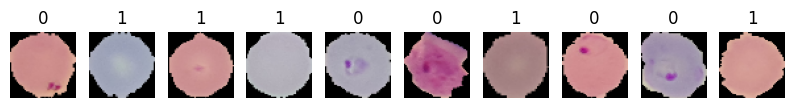

In [14]:
images, labels = next(iter(train_ds))

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow((images[i].numpy()*255).astype('uint8'))
    plt.title(labels[i].numpy())
    plt.axis('off')
plt.show()

## deep CNN 모델 생성


In [15]:
def create_model(m):
    model = Sequential()
    model.add(Conv2D(4*m, (3, 3), activation='relu', input_shape=(50, 50, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(8*m, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16*m, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(16*m, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model(1)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 4)         112       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 8)         296       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 16)          1168      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 16)         0

## Train and test the CNN

주요 분류 메트릭을 제공하는 classification_report 함수를 사용하여 예측 정확도를 측정합니다. 또한 공식을 알 수 있도록 이러한 메트릭을 개별적으로 표시합니다.

- 정밀도: 음성인 샘플을 양성으로 분류하지 않는 분류기의 능력.
- Recall: 모든 양성 샘플을 찾는 분류기의 능력
- f1: 정밀도와 재현율의 조화 평균

- epoch 수를 20으로 하면 더 좋은 성능이 나오지만 실행 시간을 고려하여 10 epoch 만 수행

In [16]:
history = model.fit(train_ds, epochs=10, verbose=1, validation_data=test_ds)

Epoch 1/10
302/302 [==============================] - 28s 43ms/step - loss: 0.9981 - accuracy: 0.4949 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 2/10
302/302 [==============================] - 17s 38ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.5003
Epoch 3/10
302/302 [==============================] - 15s 37ms/step - loss: 0.6932 - accuracy: 0.4980 - val_loss: 0.6930 - val_accuracy: 0.5053
Epoch 4/10
302/302 [==============================] - 17s 41ms/step - loss: 0.6929 - accuracy: 0.5034 - val_loss: 0.6931 - val_accuracy: 0.5043
Epoch 5/10
302/302 [==============================] - 16s 38ms/step - loss: 0.6925 - accuracy: 0.5099 - val_loss: 0.6933 - val_accuracy: 0.5005
Epoch 6/10
302/302 [==============================] - 17s 43ms/step - loss: 0.6913 - accuracy: 0.5228 - val_loss: 0.6841 - val_accuracy: 0.6047
Epoch 7/10
302/302 [==============================] - 18s 42ms/step - loss: 0.6881 - accuracy: 0.5356 - val_loss: 0.6792 - val_accuracy:

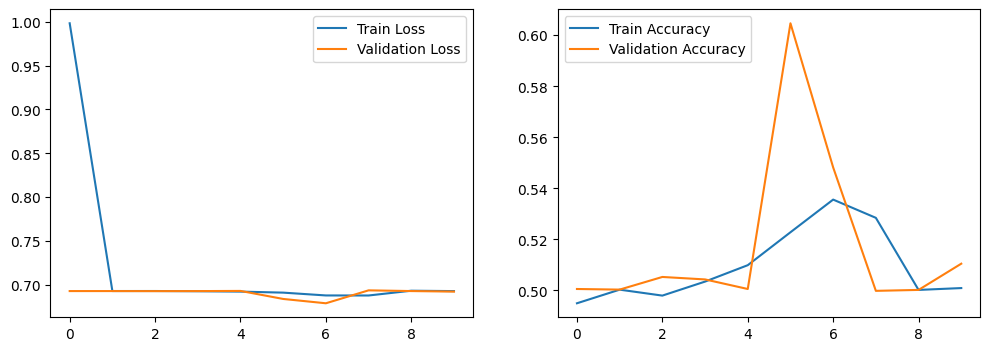

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

In [18]:
# 이미지와 레이블을 NumPy 배열로 추출
images_list = [image.numpy() for image, _ in test_ds.unbatch()]
labels_list = [label.numpy() for _, label in test_ds.unbatch()]

test_images_array = np.array(images_list)
test_labels_array = np.array(labels_list)

In [19]:
test_images_array.shape, test_labels_array.shape

((8267, 50, 50, 3), (8267,))

In [20]:
y_pred = model.predict(test_images_array, verbose=0) > 0.5

In [21]:
# accuracy = (true positives + true negatives) / (positives + negatives)
print('accuracy = {:.2f}'.format(accuracy_score(test_labels_array, y_pred)))
# precision = true positives / (true positives + false positives)
print('precision = {:.2f}'.format(precision_score(test_labels_array, y_pred)))
# recall = true positives / (true positives + false negatives)
print('recall = {:.2f}'.format(recall_score(test_labels_array, y_pred)))
# f1 = 2 * (precision * recall) / (precision + recall)
print('f1 score = {:.2f}'.format(f1_score(test_labels_array, y_pred)))

accuracy = 0.51
precision = 0.51
recall = 0.99
f1 score = 0.67


## Create the CNN models ensemble
하나의 CNN 모델로 좋은 정확도를 달성할 수 있다는 것을 알았으므로 CNN 모델의 앙상블을 시도해 봅니다.

In [22]:
models = {}
for i in range(1, 4):
    newmodel = create_model(i)
    models[i] = newmodel

models

{1: <keras.engine.sequential.Sequential at 0x7e0564c2a3e0>,
 2: <keras.engine.sequential.Sequential at 0x7e0564c2bd60>,
 3: <keras.engine.sequential.Sequential at 0x7e0564c51f60>}

## 앙상블할 모델들을 훈련하 예측을 수행합니다.
동일한 데이터 세트를 사용하여 각 모델을 개별적으로 훈련합니다.

완료되면 예측을 생성하고 배열 `predictions_hard`에 추가합니다.

In [23]:
for k in models:
    models[k].fit(train_ds, epochs=10, verbose=1, validation_data=test_ds)

Epoch 1/10
302/302 [==============================] - 19s 43ms/step - loss: 1.6093 - accuracy: 0.5015 - val_loss: 0.6933 - val_accuracy: 0.4993
Epoch 2/10
302/302 [==============================] - 22s 55ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6933 - val_accuracy: 0.4993
Epoch 3/10
302/302 [==============================] - 16s 36ms/step - loss: 0.6931 - accuracy: 0.4998 - val_loss: 0.6933 - val_accuracy: 0.4995
Epoch 4/10
302/302 [==============================] - 17s 39ms/step - loss: 0.6939 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 5/10
302/302 [==============================] - 16s 40ms/step - loss: 0.6931 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 6/10
302/302 [==============================] - 17s 39ms/step - loss: 0.6933 - accuracy: 0.4918 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 7/10
302/302 [==============================] - 16s 39ms/step - loss: 0.6932 - accuracy: 0.4954 - val_loss: 0.6932 - val_accuracy:

In [24]:
predictions_hard = []
for k in models:
    y_pred = models[k].predict(test_images_array, verbose=0) > 0.5
    print('accuracy = {:.2f}'.format(accuracy_score(test_labels_array, y_pred)))
    predictions_hard.append(y_pred)

accuracy = 0.50
accuracy = 0.94
accuracy = 0.95


## 앙상블에 hard voting 적용
Hard Voting은 다수결에 따라 클래스를 결정하는 것입니다. 다른 것보다 더 자주 예측된 클래스를 얻기 위해 `mode()` 통계 함수를 사용할 것입니다.  

`mode()` 함수는 최빈값을 의미합니다.

In [25]:
predictions_hard[0].shape

(8267, 1)

In [26]:
voting_hard = []
for i in range(len(test_labels_array)):
    # 3개 모델의 i번째 예측 결과 중 최빈값을 찾아 voting_hard에 추가
    voting_hard += [statistics.mode([predictions_hard[0][i][0], predictions_hard[1][i][0], predictions_hard[2][i][0]])]

In [27]:
from sklearn.metrics import classification_report
print(classification_report(test_labels_array, voting_hard))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      4138
           1       0.95      0.93      0.94      4129

    accuracy                           0.94      8267
   macro avg       0.94      0.94      0.94      8267
weighted avg       0.94      0.94      0.94      8267

